In [89]:
import pandas as pd
import seaborn as sns
import numpy as np
from rdkit import Chem
from rdkit.Chem.Descriptors import MolLogP
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from umap import UMAP

Make Pandas use Seaborn for plots

In [5]:
sns.set()

Enable Pandas progress_apply

In [6]:
tqdm.pandas()

A few settings to make plots look better. Here's a link to [my gist](https://gist.github.com/PatWalters/1b7600dd6d195e2cb8dded8454e1777e) with a bunch of tricks for making Seaborn plots look better. 

In [64]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')

Examine solubility data from https://www.nature.com/articles/s41597-019-0151-1

In [65]:
df = pd.read_csv("curated-solubility-dataset.csv")

In [66]:
df

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.000000,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.000000,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.000000,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.000000,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.000000,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,I-84,tetracaine,InChI=1S/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9...,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,0.000000,1,G1,264.369,...,8.0,106.0,1.0,0.0,0.0,1.0,41.57,115.300645,2.394548e+00,374.236893
9978,I-85,tetracycline,InChI=1S/C22H24N2O8/c1-21(31)8-5-4-6-11(25)12(...,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,0.000000,1,G1,444.440,...,2.0,170.0,1.0,0.0,3.0,4.0,181.62,182.429237,2.047922e+00,1148.584975
9979,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,G5,150.221,...,1.0,60.0,1.0,0.0,0.0,1.0,20.23,67.685405,3.092720e+00,251.049732
9980,I-93,verapamil,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,0.000000,1,G1,454.611,...,13.0,180.0,2.0,0.0,0.0,2.0,63.95,198.569223,2.023333e+00,938.203977


- G1 - occurs once in the dataset
- G2 - occurs twice in the dataset, SD > 0.5
- G3 - occurs twice in the dataset, SD <= 0.5
- G4 - occurs three or more times in the dataset, SD > 0.5
- G5 - occurs three or more times in the dataset, SD <= 0.5

In [67]:
df.Group.value_counts()

G1    7746
G3    1182
G5     636
G2     235
G4     183
Name: Group, dtype: int64

In [68]:
df.Group.value_counts(normalize=True)

G1    0.775997
G3    0.118413
G5    0.063715
G2    0.023542
G4    0.018333
Name: Group, dtype: float64

<AxesSubplot:>

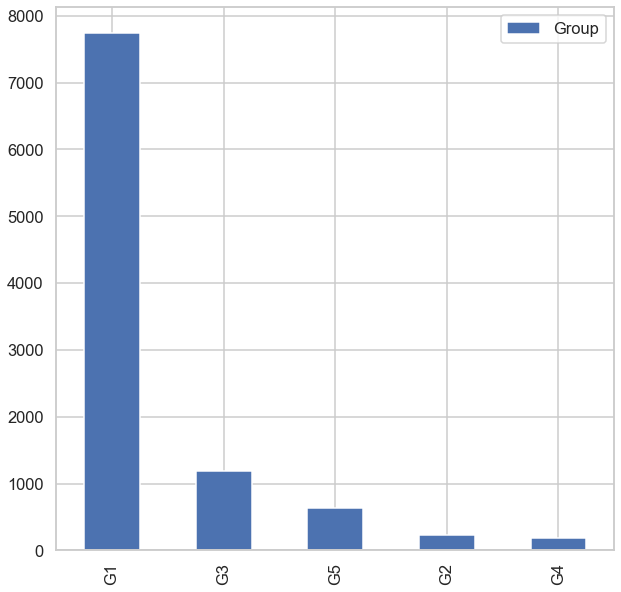

In [69]:
df.Group.value_counts().to_frame().plot(kind="bar")

In [70]:
df_ok = df.query("Group in ['G3','G5']").copy()
df_ok.shape

(1818, 26)

Plot a frequency distribution for the solubility data using Seaborn's [displot](https://seaborn.pydata.org/generated/seaborn.displot.html)

Experiment with
- kind = "kde"
- kind = "hist"
- kind = "ecdf"

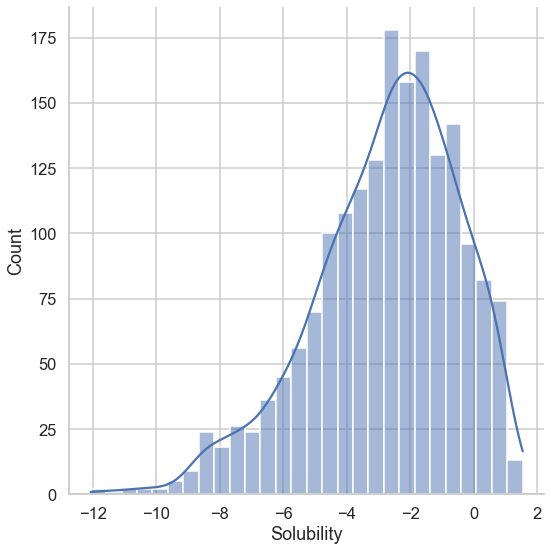

In [71]:
sns.displot(x=df_ok.Solubility,kind="hist",kde=True, height=8)

Let's bin the data
- &gt;200 uM (green)
- 30-200 uM (yellow)
- <30 uM (red)

In [72]:
bins = [np.log10(x*1e-6) for x in [30,200]]
bins = [-100] + bins + [100]
df_ok['bin'] = pd.cut(df.Solubility,bins=bins,labels=["Low","Medium","High"])

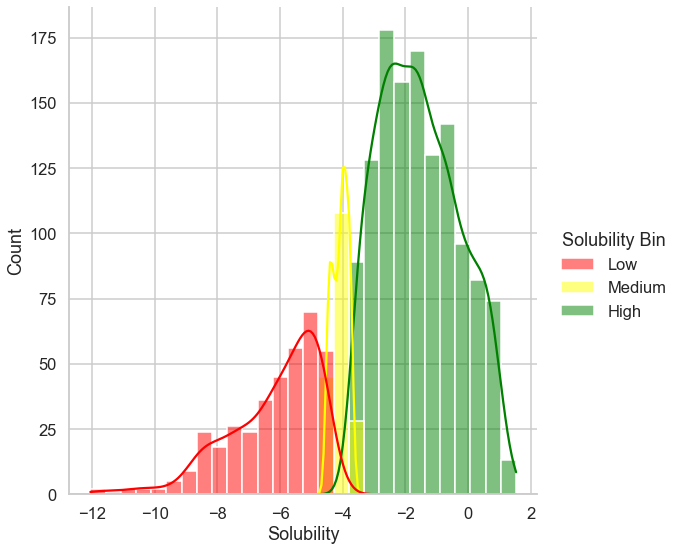

In [76]:
color_map_3 = {"Low":"red","Medium":"yellow","High":"green"}
g = sns.displot(x="Solubility",kind="hist",kde=True, height=8, hue="bin",data=df_ok,palette=color_map_3)
g.fig.legends[0].set_title("Solubility Bin")

Text(0.5, 0, 'Solubility Bin')

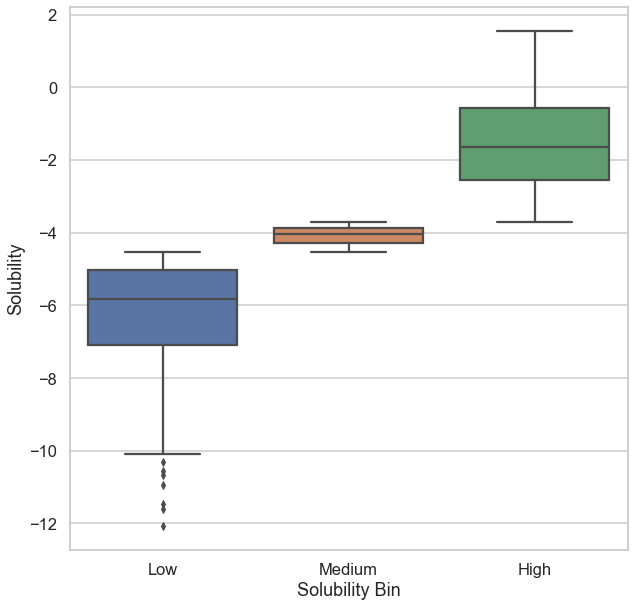

In [105]:
ax = sns.boxplot(x="bin",y="Solubility",data=df_ok)
ax.set_xlabel("Solubility Bin")

In [77]:
df_ok['is_sol'] = [True if x == "High" else False for x in df_ok.bin]

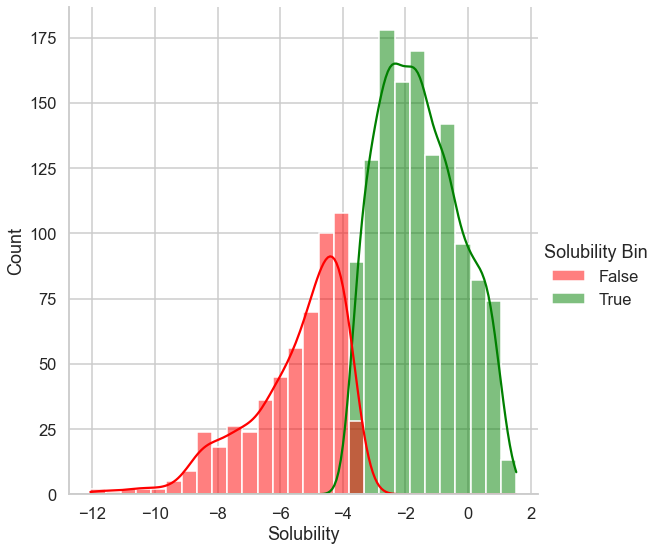

In [79]:
color_map_2 = {False :"red", True: "green"}
g = sns.displot(x="Solubility",kind="hist",kde=True, height=8, hue="is_sol",data=df_ok,palette=color_map_2)
g.fig.legends[0].set_title("Solubility Bin")

In [93]:
desc_columns = df_ok.select_dtypes([int,float]).columns[3:]
scaler = StandardScaler()
scaled_descriptors = scaler.fit_transform(df_ok[desc_columns])

In [94]:
scaled_descriptors

array([[-0.03421464,  0.37610909, -0.01380546, ..., -0.01268003,
        -0.18563527,  0.24967466],
       [ 0.78148569,  0.46434433,  0.90842396, ...,  0.85949516,
        -1.03289335,  0.56496879],
       [ 3.34710359,  2.96942891,  4.1743229 , ...,  3.61127829,
        -2.44442362,  3.54796793],
       ...,
       [ 0.87361807,  0.71854028,  1.01705895, ...,  0.86648857,
        -0.39488545,  1.43810509],
       [-0.48072862,  0.26727001, -0.24392544, ..., -0.38299783,
         0.57238241, -0.24309817],
       [ 0.55778535,  0.49724957,  0.76564104, ...,  0.63224424,
        -0.24177776,  1.36400357]])

Use Truncated Stochastic Neighbor Embedding ([TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)) to view the relationship between solubility and our descriptors. 

In [96]:
tsne = TSNE()
tsne_crds = tsne.fit_transform(scaled_descriptors)

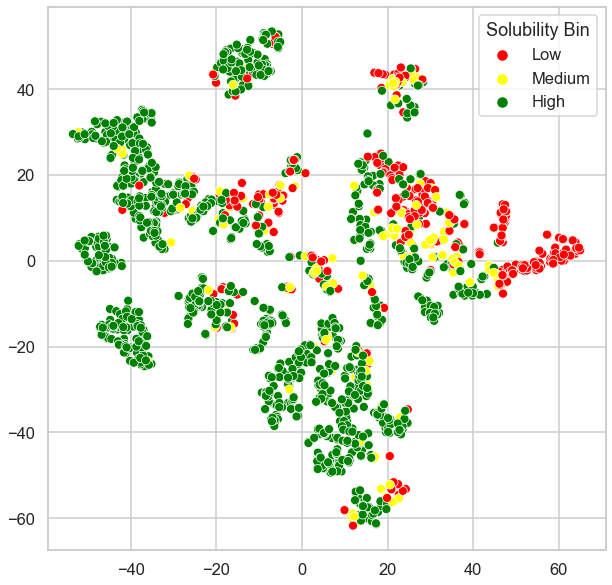

In [97]:
ax = sns.scatterplot(x=tsne_crds[:,0],y=tsne_crds[:,1],hue=df_ok.bin,palette=color_map_3)
ax.get_legend().set_title("Solubility Bin")

Some will argue that [Uniform Manifold Approximation](https://umap-learn.readthedocs.io/en/latest/) (UMAP) is a better way to do this. I'm not particularly partial to either, but here's how to do the same thing with UMAP.  As you can see, the APIs are very similar. 

In [98]:
umap = UMAP()
umap_crds = umap.fit_transform(scaled_descriptors)

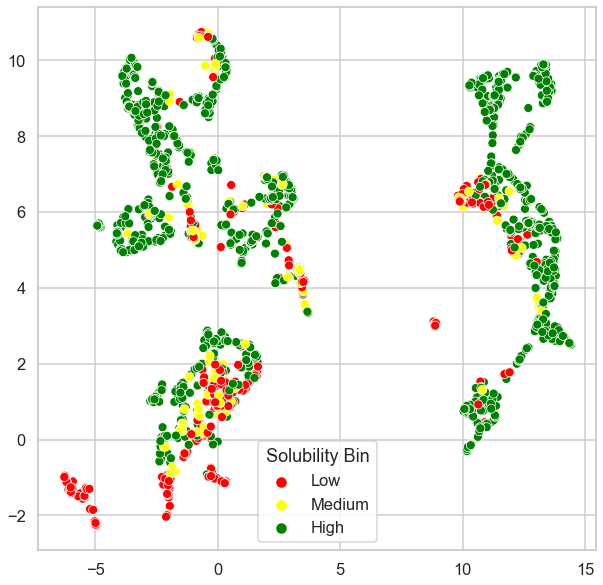

In [99]:
ax = sns.scatterplot(x=umap_crds[:,0],y=umap_crds[:,1],hue=df_ok.bin,palette=color_map_3)
ax.get_legend().set_title("Solubility Bin")

Note that we are only using 17 descriptors here.  In this case, we're ok running TSNE on our data.  If we have more than 50 dimensions, it's usually a good idea to run [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on the dataset before running TSNE. 

In [101]:
df_ok.to_csv("solubility_data_ok.csv",index=False)